In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0604/weights_KD_segformer_0604_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 1
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 2.6645e-05

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 548ms/step - loss: 2.6546e-05
Average validation loss: 0.7565446496009827
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 560ms/step - loss: 2.6546e-05 - val_loss: 0.7565
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 633ms/step - loss: 2.4245e-05 - val_loss: 0.7565
Average validation loss: 0.8191648125648499
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 645ms/step - loss: 2.4245e-05 - val_loss: 0.7879
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 823ms/step - loss: 2.0674e-05 - val_loss: 0.7879
Average validation loss: 0.717749834060669
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 834ms/step - loss: 2.0674e-05 - val_loss: 0.7645
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_5.pth'.
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 820ms/step - loss: 1.8010e-05 - val_loss: 0.7645
A

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 803ms/step - loss: 1.3981e-06
Average validation loss: 0.12337100505828857
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 814ms/step - loss: 1.3981e-06 - val_loss: 0.1234
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 785ms/step - loss: 1.2999e-06 - val_loss: 0.1234
Average validation loss: 0.1576567441225052
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 797ms/step - loss: 1.2999e-06 - val_loss: 0.1405
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 776ms/step - loss: 1.2391e-06 - val_loss: 0.1405
Average validation loss: 0.2193017154932022
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 786ms/step - loss: 1.2391e-06 - val_loss: 0.1668
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 781ms/step - loss: 1.2078e-06 - val_loss: 0.1668
Average validation loss: 0.1674940213561058
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 792ms/step - loss: 1.2078e-06 - val_loss: 0.1670
Epoch 5/10
8/8 ━━━━━━━━━━━━━━

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 907ms/step - loss: 1.1242e-06
Average validation loss: 0.07970192035039265
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 918ms/step - loss: 1.1242e-06 - val_loss: 0.0797
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 844ms/step - loss: 1.0769e-06 - val_loss: 0.0797
Average validation loss: 0.05182335867236058
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 856ms/step - loss: 1.0769e-06 - val_loss: 0.0658
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 838ms/step - loss: 1.0086e-06 - val_loss: 0.0658
Average validation loss: 0.04279414098709822
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 850ms/step - loss: 1.0086e-06 - val_loss: 0.0581
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\w

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 762ms/step - loss: 6.1807e-07
Average validation loss: 0.021075892145745456
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 773ms/step - loss: 6.1807e-07 - val_loss: 0.0211
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 809ms/step - loss: 5.2503e-07 - val_loss: 0.0211
Average validation loss: 0.055044473614543676
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 819ms/step - loss: 5.2503e-07 - val_loss: 0.0381
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 788ms/step - loss: 4.9398e-07 - val_loss: 0.0381
Average validation loss: 0.03642347228014842
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 802ms/step - loss: 4.9398e-07 - val_loss: 0.0375
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 51s 764ms/step - loss: 4.7787e-07 - val_loss: 0.0375
Average validation loss: 0.049634505761787295
16/16 ━━━━━━━━━━━━━━━━━━━━ 51s 777ms/step - loss: 4.7787e-07 - val_loss: 0.0405
Epoch

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 829ms/step - loss: 2.6170e-07
Average validation loss: 0.008673537615686655
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 839ms/step - loss: 2.6170e-07 - val_loss: 0.0087
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 831ms/step - loss: 2.8334e-07 - val_loss: 0.0087
Average validation loss: 0.010720166377723217
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 841ms/step - loss: 2.8334e-07 - val_loss: 0.0097
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 839ms/step - loss: 2.8351e-07 - val_loss: 0.0097
Average validation loss: 0.017441048752516508
20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 849ms/step - loss: 2.8351e-07 - val_loss: 0.0123
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 776ms/step - loss: 2.5548e-07 - val_loss: 0.0123
Average validation loss: 0.019826049357652663
20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 787ms/step - loss: 2.5548e-07 - val_loss: 0.0142
Epoc

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 848ms/step - loss: 2.3565e-07
Average validation loss: 0.010309096736212572
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 859ms/step - loss: 2.3565e-07 - val_loss: 0.0103
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 849ms/step - loss: 2.1879e-07 - val_loss: 0.0103
Average validation loss: 0.00879356119548902
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 860ms/step - loss: 2.1879e-07 - val_loss: 0.0096
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 60s 794ms/step - loss: 1.8972e-07 - val_loss: 0.0096
Average validation loss: 0.008117543591652066
24/24 ━━━━━━━━━━━━━━━━━━━━ 61s 804ms/step - loss: 1.8972e-07 - val_loss: 0.0091
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 36s 911ms/step - loss: 6.1042e-07
Average validation loss: 0.047381852520629764
40/40 ━━━━━━━━━━━━━━━━━━━━ 37s 923ms/step - loss: 6.1042e-07 - val_loss: 0.0474
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 68s 776ms/step - loss: 4.9425e-07 - val_loss: 0.0474
Average validation loss: 0.023120050493162125
40/40 ━━━━━━━━━━━━━━━━━━━━ 69s 789ms/step - loss: 4.9425e-07 - val_loss: 0.0353
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 100s 776ms/step - loss: 4.0890e-07 - val_loss: 0.0353
Average validation loss: 0.03163502655224874
40/40 ━━━━━━━━━━━━━━━━━━━━ 100s 789ms/step - loss: 4.0890e-07 - val_loss: 0.0340
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 131s 778ms/step - loss: 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 786ms/step - loss: 2.5294e-07
Average validation loss: 0.01474422601556095
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 798ms/step - loss: 2.5294e-07 - val_loss: 0.0147
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 76s 788ms/step - loss: 2.0159e-07 - val_loss: 0.0147
Average validation loss: 0.013503042554172376
48/48 ━━━━━━━━━━━━━━━━━━━━ 77s 800ms/step - loss: 2.0159e-07 - val_loss: 0.0141
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 115s 788ms/step - loss: 1.8135e-07 - val_loss: 0.0141
Average validation loss: 0.010646415777349224
48/48 ━━━━━━━━━━━━━━━━━━━━ 115s 800ms/step - loss: 1.8135e-07 - val_loss: 0.0130
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 800ms/step - loss: 1.4387e-07
Average validation loss: 0.02256328083707818
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 811ms/step - loss: 1.4387e-07 - val_loss: 0.0226
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 89s 786ms/step - loss: 1.4569e-07 - val_loss: 0.0226
Average validation loss: 0.03751722862944007
56/56 ━━━━━━━━━━━━━━━━━━━━ 90s 798ms/step - loss: 1.4569e-07 - val_loss: 0.0300
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 134s 787ms/step - loss: 1.3271e-07 - val_loss: 0.0300
Average validation loss: 0.025650273343282088
56/56 ━━━━━━━━━━━━━━━━━━━━ 135s 798ms/step - loss: 1.3271e-07 - val_loss: 0.0286
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 179s 791ms/step - loss: 1.2083e-07 - val_loss: 0.0286
Average validation loss: 0.02820573960031782
56/56 ━━━━━━━━━━━━━━━━━━━━ 180s 803ms/step - loss: 1.2083e-07 - val_loss: 0.0285
Epo

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 776ms/step - loss: 1.2459e-07
Average validation loss: 0.012520624790340662
64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 787ms/step - loss: 1.2459e-07 - val_loss: 0.0125
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 101s 797ms/step - loss: 1.0857e-07 - val_loss: 0.0125
Average validation loss: 0.019693676687893458
64/64 ━━━━━━━━━━━━━━━━━━━━ 102s 809ms/step - loss: 1.0857e-07 - val_loss: 0.0161
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 152s 780ms/step - loss: 9.5061e-08 - val_loss: 0.0161
Average validation loss: 0.025629195326473564
64/64 ━━━━━━━━━━━━━━━━━━━━ 153s 791ms/step - loss: 9.5061e-08 - val_loss: 0.0193
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 203s 785ms/step - loss: 8.5709e-08 - val_loss: 0.0193
Average validation loss: 0.02048667226335965
64/64 ━━━━━━━━━━━━━━━━━━━━ 204s 796ms/step - loss: 8.5709e-08 - val_loss: 0.0196

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 789ms/step - loss: 7.9403e-08
Average validation loss: 0.019823253093313217
72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 800ms/step - loss: 7.9403e-08 - val_loss: 0.0198
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 113s 775ms/step - loss: 6.4987e-08 - val_loss: 0.0198
Average validation loss: 0.029304821374050032
72/72 ━━━━━━━━━━━━━━━━━━━━ 114s 786ms/step - loss: 6.4987e-08 - val_loss: 0.0246
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 170s 774ms/step - loss: 5.6662e-08 - val_loss: 0.0246
Average validation loss: 0.027255495082095474
72/72 ━━━━━━━━━━━━━━━━━━━━ 171s 785ms/step - loss: 5.6662e-08 - val_loss: 0.0255
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 227s 777ms/step - loss: 5.0505e-08 - val_loss: 0.0255
Average validation loss: 0.022793854677325323
72/72 ━━━━━━━━━━━━━━━━━━━━ 227s 787ms/step - loss: 5.0505e-08 - val_loss: 0.024

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 62s 770ms/step - loss: 8.7221e-08
Average validation loss: 0.014965724156354554
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 781ms/step - loss: 8.7221e-08 - val_loss: 0.0150
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 124s 773ms/step - loss: 7.5285e-08 - val_loss: 0.0150
Average validation loss: 0.011295259685721249
80/80 ━━━━━━━━━━━━━━━━━━━━ 125s 783ms/step - loss: 7.5285e-08 - val_loss: 0.0131
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 187s 773ms/step - loss: 6.8177e-08 - val_loss: 0.0131
Average validation loss: 0.01771727401064709
80/80 ━━━━━━━━━━━━━━━━━━━━ 188s 784ms/step - loss: 6.8177e-08 - val_loss: 0.0147
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 250s 774ms/step - lo

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 74s 773ms/step - loss: 1.5273e-07
Average validation loss: 0.01878857805665272
96/96 ━━━━━━━━━━━━━━━━━━━━ 75s 785ms/step - loss: 1.5273e-07 - val_loss: 0.0188
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 150s 773ms/step - loss: 1.2131e-07 - val_loss: 0.0188
Average validation loss: 0.020488468018205214
96/96 ━━━━━━━━━━━━━━━━━━━━ 151s 785ms/step - loss: 1.2131e-07 - val_loss: 0.0196
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 225s 774ms/step - loss: 9.7220e-08 - val_loss: 0.0196
Average validation loss: 0.023355800134595484
96/96 ━━━━━━━━━━━━━━━━━━━━ 226s 786ms/step - loss: 9.7220e-08 - val_loss: 0.0209
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 300s 774ms/step - loss: 8.5013e-08 - val_loss: 0.0209
Average validation loss: 0.02106925260159187
96/96 ━━━━━━━━━━━━━━━━━━━━ 302s 786ms/step - loss: 8.5013e-08 - val_loss: 0.0209

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 93s 777ms/step - loss: 2.7720e-07
Average validation loss: 0.016300342441536487
120/120 ━━━━━━━━━━━━━━━━━━━━ 95s 788ms/step - loss: 2.7720e-07 - val_loss: 0.0163
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 188s 776ms/step - loss: 2.4241e-07 - val_loss: 0.0163
Average validation loss: 0.0191208781208843
120/120 ━━━━━━━━━━━━━━━━━━━━ 189s 788ms/step - loss: 2.4241e-07 - val_loss: 0.0177
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 282s 774ms/step - loss: 1.9673e-07 - val_loss: 0.0177
Average validation loss: 0.018099071349327762
120/120 ━━━━━━━━━━━━━━━━━━━━ 283s 786ms/step - loss: 1.9673e-07 - val_loss: 0.0178
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 377s 778ms/step - loss: 1.6916e-07 - val_loss: 0.0178
Average validation loss: 0.019783788360655308
120/120 ━━━━━━━━━━━━━━━━━━━━ 378s 789ms/step - loss: 1.6916e-07 - 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 111s 771ms/step - loss: 1.8540e-07
Average validation loss: 0.013918233821944645
144/144 ━━━━━━━━━━━━━━━━━━━━ 113s 782ms/step - loss: 1.8540e-07 - val_loss: 0.0139
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 224s 771ms/step - loss: 1.5080e-07 - val_loss: 0.0139
Average validation loss: 0.018202560944094632
144/144 ━━━━━━━━━━━━━━━━━━━━ 225s 782ms/step - loss: 1.5080e-07 - val_loss: 0.0161
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 336s 771ms/step - loss: 1.3681e-07 - val_loss: 0.0161
Average validation loss: 0.014577901863958687
144/144 ━━━━━━━━━━━━━━━━━━━━ 338s 782ms/step - loss: 1.3681e-07 - val_loss: 0.0156
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 449s 773ms/step - loss: 1.2254e-07 - val_loss: 0.0156
Average validation loss: 0.01855759724922892
144/144 ━━━━━━━━━━━━━━━━━━━━ 451s 784ms/step - loss: 1.2254e-07

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 124s 774ms/step - loss: 1.1003e-07
Average validation loss: 0.02128391871228814
160/160 ━━━━━━━━━━━━━━━━━━━━ 126s 785ms/step - loss: 1.1003e-07 - val_loss: 0.0213
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 250s 775ms/step - loss: 8.8508e-08 - val_loss: 0.0213
Average validation loss: 0.016502435837173833
160/160 ━━━━━━━━━━━━━━━━━━━━ 251s 786ms/step - loss: 8.8508e-08 - val_loss: 0.0189
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 375s 774ms/step - loss: 7.6493e-08 - val_loss: 0.0189
Average validation loss: 0.02222770655644126
160/160 ━━━━━━━━━━━━━━━━━━━━ 377s 785ms/step - loss: 7.6493e-08 - val_loss: 0.0200
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 500s 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 156s 782ms/step - loss: 1.6576e-07
Average validation loss: 0.020013501048088075
200/200 ━━━━━━━━━━━━━━━━━━━━ 159s 793ms/step - loss: 1.6576e-07 - val_loss: 0.0200
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 315s 783ms/step - loss: 1.3521e-07 - val_loss: 0.0200
Average validation loss: 0.01667299787979573
200/200 ━━━━━━━━━━━━━━━━━━━━ 317s 794ms/step - loss: 1.3521e-07 - val_loss: 0.0183
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 474s 781ms/step - loss: 1.1323e-07 - val_loss: 0.0183
Average validation loss: 0.016040959833189844
200/200 ━━━━━━━━━━━━━━━━━━━━ 476s 792ms/step - loss: 1.1323e-07 - val_loss: 0.0176
Saved model weights to 'c:\天_11157065\git\Ri

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 189s 789ms/step - loss: 1.1126e-07
Average validation loss: 0.020468986890045927
240/240 ━━━━━━━━━━━━━━━━━━━━ 192s 800ms/step - loss: 1.1126e-07 - val_loss: 0.0205
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 380s 785ms/step - loss: 9.2772e-08 - val_loss: 0.0205
Average validation loss: 0.01952127090092593
240/240 ━━━━━━━━━━━━━━━━━━━━ 383s 796ms/step - loss: 9.2772e-08 - val_loss: 0.0200
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 571s 785ms/step - loss: 7.9186e-08 - val_loss: 0.0200
Average validation loss: 0.017191860291253153
240/240 ━━━━━━━━━━━━━━━━━━━━ 574s 796ms/step - loss: 7.9186e-08 - val_loss: 0.0191
Saved model weights to 'c:\天_11157065\git\Ri

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.171019070148468, 0.0721960336342454, 0.034941466152668, 0.019355315387947485, 0.014166592922061683, 0.01585096398581906, 0.02050339356029872, 0.018063093792588917, 0.016526501946500502, 0.01443410836851399, 0.015655257328051245, 0.01387614728952758, 0.015294185491802637, 0.01750795656341749, 0.01634239351312216, 0.01525451818550937, 0.016907363433414136, 0.015211096527976526]
std_val_losses =  [0.1839502373149448, 0.06141059861257149, 0.01518983913896795, 0.010435591889177193, 0.004227450480961265, 0.008275374684087884, 0.007126464437361158, 0.004780335518923499, 0.006375698617772297, 0.004480666563777182, 0.005207610948540438, 0.0023554688292965037, 0.004378897933184546, 0.002704627821904866, 0.0024368186921625286, 0.002839870728963992, 0.0020208897906037024, 0.001987128911905059]


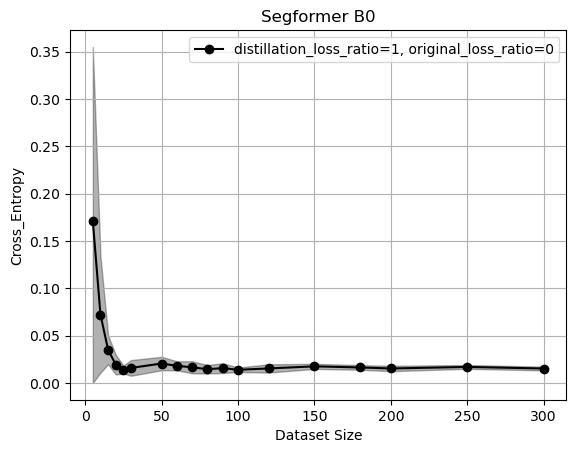

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0604')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.png"))

plt.show()